# 第6章 感度分析

観測可能な交絡因子の影響を取り除いて因果効果を推定する方法を今まで扱ってきた。この章では、未観測の交絡因子の影響に対応する方法として、感度分析を扱う。

未観測の交絡因子の影響に対応するには、以下の方法がある
* 自然実験(準実験): RCTが行われたかのような状況を作り出し、条件付き独立性を満たす(未観測のものも含め、交絡因子の影響を除外する)
    * 回帰不連続デザイン(RDD): 設定した境界値付近のみでRCTに近い状況を作り出す
    * 操作変数法: 特定の条件を満たす、操作変数Zを設定してRCTに近い状況を作りだす
    * 差分の差分法(DiD): 処置群・対象群それぞれの処置前・処置後の差分を用いて、処置群・対象群の差分を取る。結果変数の時系列トレンドの影響を取り除く

* 感度分析(この章): 未観測の交絡因子の影響を評価

## 6.1 感度分析を用いた分析の全体像

感度分析: 仮定したモデルに仮のみ観測の交絡因子などの様々なデータを入力して、推定した因果効果についての妥当性を評価するための方法

入力を変えたときの出力について
1. 変化の方法(正負)
2. その度合い(強さ)

を評価する手法。

そもそも観察研究では、処置の割当について条件付き独立性の仮定の成立を証明できる場合がほとんどない。

そのため、自然実験や感度分析で未観測の交絡因子にアプローチすることが必要。

今回説明する感度分析の方法
* 部分決定係数: 未観測の交絡因子が存在する場合に、その方向と影響を既存の共変量の影響と比較しながら定量的に評価する
* E-Value: 特に疫学の分野で使用される
* オースティンプロット: 機械学習を用いる

## 6.2 部分決定係数を用いた感度分析

### 6.2.1 部分決定係数を用いた感度分析の概要

未観測の交絡因子を仮設定し、その交絡因子が結果変数と処置変数に与える影響を変化させた場合の結果を評価する。

* 未観測の交絡因子Uを用いたパラメトリックモデルを考える
* Uの値は影響する/しない(1/0)の2値で、ベルヌーイ分布(Bern(1/2))に従うとする
* XとUが、Tに影響し、XとTとUが、Yに影響すると仮定する
* このときTのモデルはロジスティック回帰モデルと仮定
    * 処置は1,0の2値
    * sigはシグモイド関数
* Yのモデルは線形回帰モデルと仮定
    * 結果変数は分散$\sigma^2$の正規分布に従う連続値であると仮定
* それぞれの回帰モデルでのパラメータ(係数)を図6.3のモデルのように、$\alpha, \beta, \gamma, \delta. \tau$と置く

![図6.3](images/chap6/image.png)

$U_i$が観測されていないので、各パラメータの推定はできないが
* $\alpha$: $U_i$が$T_i$にどれだけ影響するかを表す
* $\delta$: $U_i$が$Y_i$にどれだけ影響するかを表す

を用いて、$U_i$の影響を判断できる。

* 部分決定係数の計算方法


決定係数$R^2$
$$
R^2
= 1 - 
\frac{\sum\limits_{i=1}^n \left(Y_i - \hat{Y}_i \right)^2}
     {\sum\limits_{i=1}^n \left(Y_i - \overline{Y} \right)^2}
$$

右辺分子の予測値の残差平方和$\sum\limits_{i=1}^n \left(Y_i - \hat{Y}_i \right)^2$はモデルの適合度が高いと小さくなるため0に近づく。つまり$R^2$は、
* 1に近い: モデルの適合度が高い
* 0に近い: モデルの適合度が低い

対して部分決定係数$R^2(Y, par)$は、モデルがどれだけデータを正確に説明できるかを評価するための式であり、
* $RSS_{full}$: 未観測の交絡因子Uもすべて含んだFullモデルを仮定したときの残差平方和
* $RSS_{reduced}$: 未観測の交絡因子Uを含まない、観測変数のみを使用したモデルの残差平方和
$$
R^2(Y, par)
= 1 - 
\frac{RSS_{full}}
     {RSS_{reduced}}
$$

と表されるため、
* 1に近い: $RSS_{full} \lt RSS_{reduced}$であり、Uの影響が大きい
* 0に近い: $RSS_{full} \fallingdotseq RSS_{reduced}$であり、Uの影響が小さい

部分決定係数を使用するメリット
1. 交絡因子の強さを比較可能
2. 視覚的に交絡因子の強さを把握可能


### 6.2.2 部分決定係数を用いた感度分析の実行手順

Pysensemakrを用いる

問題設定: デジタル広告の影響はどれほどか?また、未観測の交絡因子の影響は大きいか?

#### Step 1 ライブラリの準備、データの確認


In [2]:
import numpy as np
import pandas as pd

# サンプルデータの生成
rng = np.random.default_rng(1)
n = 1000
DigitalAdSpend = rng.normal(20, 5, n)
CustomerAge = rng.integers(20, 50, n)
PrevPurchase = rng.choice([0, 1], n)
Region = rng.choice([1, 2, 3], n)

# サンプルの売上データを生成:
# 売上は、
# デジタル広告費、
# 顧客の年齢、
# 購買履歴、
# 切片(100)、
# ランダムな数値
# から構成される設定
SalesRevenue = (
    100
    + 3 * DigitalAdSpend
    + 0.5 * CustomerAge
    + 2 * PrevPurchase
    + rng.normal(0, 10, n)
)
df = pd.DataFrame(
    {
        "SalesRevenue": SalesRevenue,  # 売上
        "DigitalAdSpend": DigitalAdSpend,  # デジタル広告費
        "CustomerAge": CustomerAge,  # 顧客の年齢
        "PrevPurchase": PrevPurchase,  # 購買履歴
        "Region": Region,  # 地域
    },
)

#### Step 2 DAGの確認

あくまで仮説として、以下のように設定する

![図6.4](images/chap6/image-1.png)

未観測の交絡因子については、直接的に変数の設定ができないので、Step4で共変量の「顧客の年齢」の体数倍の影響があるとして設定する

#### Step 3 モデリング

説明変数を以下として、線形回帰モデルを仮定したモデリングを行う
* デジタル広告費
* 顧客の年齢
* 購買履歴
* 地域

In [3]:
import statsmodels.formula.api as smf

reg_model = smf.ols(
    formula="SalesRevenue ~ DigitalAdSpend + CustomerAge + PrevPurchase + Region",
    data=df,
)
sales_model = reg_model.fit()

#### Step 4 感度分析の実行 ~ Step 5 結果の評価

感度分析を実行する。

デジタル広告の影響と併せて、例として顧客の年齢(CustomerAge)に対して、その1倍、2倍、3倍の影響を持つ未観測の交絡因子が存在した場合に、デジタル広告費の影響がどのように変化するかを分析する

具体的には、 以下のパラメータを設定する。
* kd: 未観測の交絡因子が処置変数に与える影響について、指定した共変量(顧客の年齢)の何倍の影響になるか
* ky: 未観測の交絡因子が結果変数に与える影響について、指定した共変量(顧客の年齢)の何倍の影響になるか

In [4]:
import sensemakr as smkr

sales_sense = smkr.Sensemakr(
    model=sales_model,
    treatment="DigitalAdSpend",
    benchmark_covariates=["CustomerAge"],
    kd=[1, 2, 3],
    ky=[1, 2, 3],
    q=1.0,
    alpha=0.05,
    reduce=True,
)
sales_sense.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: SalesRevenue ~ DigitalAdSpend + CustomerAge + PrevPurchase + Region

Null hypothesis: q = 1.0 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' DigitalAdSpend ':
  Coef. estimate: 3.068
  Standard Error: 0.064
  t-value: 48.082 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.699
  Robustness Value, q = 1.0 : 0.755
  Robustness Value, q = 1.0 alpha = 0.05 : 0.742 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 69.911 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Value, q = 1.0 : unobserved confound

/Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap5/.venv/lib/python3.11/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/Users/sean/Documents/myscript/causal-inference-basic-book/notebook/chap5/.venv/lib/python3.11/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float


#### 主要な項目の解説
```bash
Unadjusted Estimates of ' DigitalAdSpend ':
  Coef. estimate: 3.068  # デジタル広告費の影響
  Standard Error: 0.064  # 標準誤差
  t-value: 48.082  # t値
```
デジタル広告費は非常に強い正の影響を与えている

```bash
Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.699  # 1. 処置変数と結果変数における部分決定係数
  Robustness Value, q = 1.0 : 0.755  # 2. ロバストネス値(obustness Value)
  Robustness Value, q = 1.0 alpha = 0.05 : 0.742  # 3. 
```

1. デジタル広告費が売上高に与える影響を説明できる割合(寄与率)が大きい。以下summaryの英文の訳。
   
   "未観測の交絡因子が結果変数に対する残差の分散の100%を説明する場合、推定された係数(デジタル広告費の影響)を完全に説明するためには、少なくとも処置変数に対する残差の分散の69.911%を説明する必要がある。"

2. 未観測の交絡因子が処置変数と結果変数に与える影響を定量的に評価するための指標。
   この値が大きいほど、処置変数と結果変数は未観測の交因子の影響を受けません（以下、未観測の交絡因子の影響を受けないことロバストネス値が0.755であることは、処置変数と結果変数の両方の残差の分散のうち、75.48%を説明する程の影響を及ぼす未観測の交絡因子が存在しない限り、デジタル広告費の影響はロバストであると言える。

3.  この値(0.742)も大きく、未観測の交絡因子が非常に大きな水準(処置変数と結果変数の両方の残差の分散のうち、74.226%を説明するほど)で存在しない限り、統計的に有意な水準($\alpha = 0.05$)でデジタル広告費の影響はロバストであると言える。

```bash
Bounds on omitted variable bias:
--The table below shows the maximum strength of unobserved confounders with association with the treatment and the outcome bounded by a multiple of the observed explanatory power of the chosen benchmark covariate(s).

#              1.           2.                                        3.
      bound_label    r2dz_x   r2yz_dx       treatment  adjusted_estimate  \
0  1x CustomerAge  0.000471  0.220445  DigitalAdSpend           3.047264   
1  2x CustomerAge  0.000942  0.440891  DigitalAdSpend           3.026744   
2  3x CustomerAge  0.001413  0.661337  DigitalAdSpend           3.006214   

   adjusted_se  adjusted_t  adjusted_lower_CI  adjusted_upper_CI  
0     0.056374   54.054026           2.936638           3.157891  
1     0.047754   63.382063           2.933034           3.120454  
2     0.037175   80.867227           2.933265           3.079
```
このテーブルは、未観測の交絡因子の強さの上限を示す。特に、顧客の年齢(CustomerAge)が基準とされ、その1倍、2倍、3倍の影響を持つ未観測の交絡因子に対する調整後の推定値(調整後のデジタル広告費の係数)が示されている。

1. bound_label: シナリオを示す。"1x CustomerAge"は顧客年齢の影響の1倍という意味
2. r2dz_xとr2yz_dx: これらは処置変数と結果変数のそれぞれに対する未観測の交絡因子の部分決定係数を表す
   
   値が大きいほど未観測の交絡因子の影響が大きいと考えられる。実際にこれらの値(0.000471, 0.000942, 0.001413)は非常に小さいため、未観測の交因子の影響が非常に小さいと考えられる。

3. adjusted_estimate: これは各シナリオでの"DigitalAdSpend"の調整後の係数
   
   元の係数(3,068)に比べてこれらの値(3.047,3.028,3.006)はそれほど大きくは変わらない。これは元の推定値がロバストである可能性が高いことを示す。


最後に可視化を行う


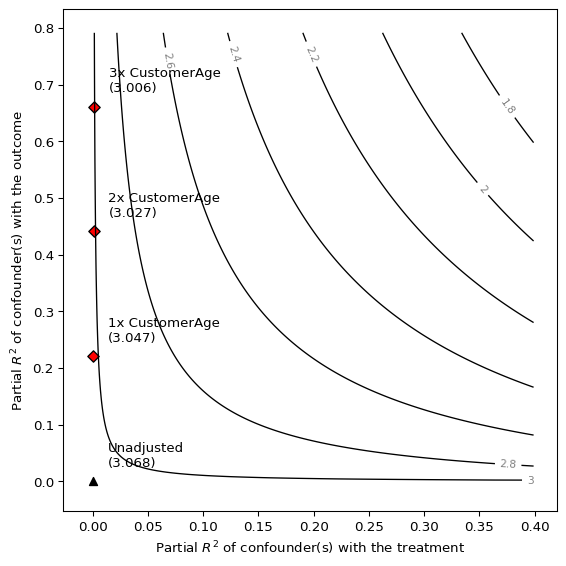

In [5]:
sales_sense.plot()

"""
* 横軸: 未観測の交絡因子によって説明される処置変数の部分決定係数.
* 縦軸: 未観測の交絡因子によって説明される結果変数の部分決定係数.
* 等高線: 感度パラメーター(0.8など)の仮定の値を使用して、
          Fullモデルの未観測の交絡因子に対して得られる調整後の推定値(adjusted estimate)。
          具体的には、調整後のデジタル広告費の影響(推定した係数)
* プロット: 顧客の年齢(CustomerAge)を基準とし、
            その1倍、2倍、3倍の影響を持つ未観測の交絡因子に対する、
            調整後の推定値(adjusted estimate)
"""

以上の分析結果から、デジタル広告費が売上に与える影響は非常に大きく(係数3.068)、未観測の交絡因子による影響は小さいと考えられる。

### 6.2.3 部分決定係数を使用した感度分析の課題

これまで説明した部分決定係数を使用した感度分析では、パラメトリック回帰モデルを使用しているため、多重共線性や非線形データへの対応が必要

## 6.3 E-Valueを用いた感度分析

### 6.3.1 E-Valueの概要

E-Value: 未観測の交絡因子が、処置と結果の両方に対して最低限どの程度関連しているかを示す指標。相対リスク(Relative Risk: RR)を用いて以下の式で表される

$$
E - Value = RR + \sqrt{RR \times (RR - 1)}
$$

* 相対リスク(RR): 主に疫学で使用される用語。